# Milestone Project 2: SkimLit

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-18489f9e-ca81-bd3a-94fa-b9ca253ab045)


## Get data

Replicating the PubMed 200k RCT paper.

In [2]:
!git clone git@github.com:Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [4]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [5]:
# Check what files are in the PubMed_20k dataset (we start small)
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [6]:
!ls pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


In [7]:
# Start using the 20k dataset with numbers replaced by @ sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [8]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

In [9]:
# Create function to read the lines of a document
def get_lines(filename):
  '''
  Reads filenames (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  '''
  with open(filename, 'r') as f:
    return f.readlines()

In [10]:
# Read in the training lines
train_lines = get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [11]:
len(train_lines)

210040

How to best represent the data

```[{'line_number': 0,   
  'target': 'BACKGROUND',
  'text': Emotional eating ...,
  'total_lines': 11}]```

> We'are classifying sequentially, so order matters

In [12]:
def preprocess_text_with_line_numbers(filename):
  '''
  Returns a list of dictionaries of abstract line data.

  Takes in filename , reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number the
  target line is.
  '''
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstrct
  abstract_samples = [] # create an empty list of abstracts

  # Loop hrough each line in the target file
  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = '' # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split('\t') # split target label from text

        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower() # lower() is a form of standardization
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the aboce condition are not fulfilled, the line contains a labeled sentence
      abstract_lines += line 
  
  return abstract_samples


In [13]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'dev.txt') # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir+'test.txt')
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 479 ms, sys: 77 ms, total: 557 ms
Wall time: 558 ms


In [14]:
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [15]:
import pandas as pd

In [16]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [17]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

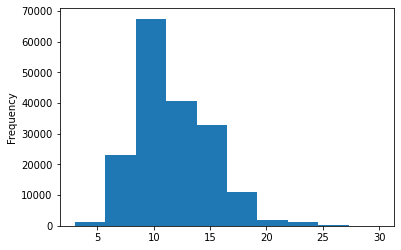

In [18]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get list of sentences

In [19]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [20]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [21]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want a non sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

In [22]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [23]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [24]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Getting a baseline model

In [25]:
# TF-IDF Multinomial Naive Bayes classifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB()) # clf -> classifier
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [26]:
# Evaluate the model
moddel_0_results = model_0.score(X=val_sentences,
                                    y=val_labels_encoded)
moddel_0_results

0.7218323844829869

In [27]:
# Make predictions using the baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [28]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download helper function script

In [29]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-21 23:43:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-21 23:43:15 (99.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [30]:
from helper_functions import calculate_results
baseline_results = calculate_results(y_true=val_labels_encoded,
                  y_pred=baseline_preds)
baseline_results # We want to beat the baseline results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data for deep sequence models

Need to create vectorization and embedding layer.

> Reminder: 
* **Text vectorization (tokenization)**: the straight mapping from token to number (can be modelled, but quickly gets too big)
* **Embedding**: richer representation of relationships between tokens (can limit size, can be learned)

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [32]:
# How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

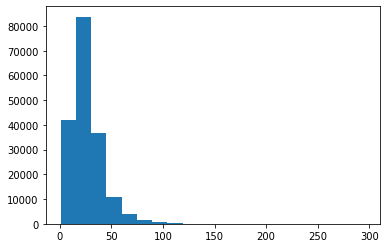

In [33]:
# Distribution
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [34]:
# how long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len # 95% of senteneces are under 55 tokens

55

In [35]:
# Maximum sequence in the training set
max(sent_lens)

296

### Create text vectorizer layer

In [36]:
# How many words are in our vocabs
max_tokens = 68000


In [37]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocbulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [38]:
# adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [39]:
# test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])}')

Text:
annual screening was offered to @ women ages @ to @ years ( risk group @ ) with epidemiologic and serum marker risk factors .

Length of text: 25

Vectorized text: [[2582  387   10 1631    6   90 1588    6   64   73   13    7 6209    3
   225 1821   73  254    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [40]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [41]:
# get the config of the text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Create custom text embedding

In [42]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes 
                               # result in drastically differnt numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths (save space),
                               name='token_embedding')

In [43]:
# Show an example embedding
print(f'Sentence before vectorization:\n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization before embedding:\n {vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embedded_sentence}\n')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization:
 annual screening was offered to @ women ages @ to @ years ( risk group @ ) with epidemiologic and serum marker risk factors .

Sentence after vectorization before embedding:
 [[2582  387   10 1631    6   90 1588    6   64   73   13    7 6209    3
   225 1821   73  254    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[ 0.02516234 -0.04967853 -0.04716914 ... -0.01193138 -0.04436119
   -0.03752737]
  [ 0.01625583 -0.02858332 -0.04741936 ... -0.04333316 -0.02249656
    0.02213133]
  [ 0.04629898  0.0198928   0.02053711 ... -0.03891259 -0.04138834
   -0.04349767]
  ...
  [ 0.0141159  -0.02697046 -0.00585854 ... -0.00445395  0.0193505
   -0.00572175]
  [ 0.0141159  -0.02697046 -0.00585854 ... -0.00445395  0.0193505
   -0.00572175]
  [ 0.0141159  -0.02697046 -0.00585854 ... -0.00445395  0.019

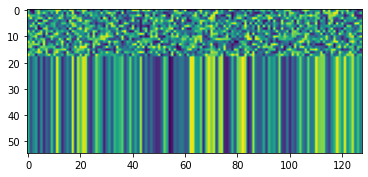

In [44]:
plt.imshow(tf.squeeze(embedded_sentence * 255))

## Creating datasets (making sure our data loads as fast as possible)
Check out:
1. https://www.tensorflow.org/guide/data_performance
2. https://www.tensorflow.org/guide/data

In [45]:
# Turn our data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [46]:
# Take the tensorslice dataset and turn them into prefetched dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # automatically prefetch as many samples as you can
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with token embeddings

In [47]:
num_classes

5

In [48]:
input_1 = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(input_1) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
output_1 = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.models.Model(input_1, output_1)

In [49]:
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [50]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 18s 6ms/step - loss: 0.9069 - accuracy: 0.6406 - val_loss: 0.6814 - val_accuracy: 0.7427
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.6559 - accuracy: 0.7573 - val_loss: 0.6265 - val_accuracy: 0.7733
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.6172 - accuracy: 0.7748 - val_loss: 0.5988 - val_accuracy: 0.7832


In [51]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 2s 3ms/step - loss: 0.6008 - accuracy: 0.7844


[0.6008021831512451, 0.7843571901321411]

In [52]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.2196164e-01, 1.7764769e-01, 9.0916693e-02, 2.7760732e-01,
        3.1866636e-02],
       [4.2646208e-01, 2.8423926e-01, 1.3772936e-02, 2.6684737e-01,
        8.6782798e-03],
       [1.2388508e-01, 6.4914473e-03, 1.4990401e-03, 8.6809397e-01,
        3.0373616e-05],
       ...,
       [4.9471564e-06, 7.1398891e-04, 6.4560201e-04, 2.9466482e-06,
        9.9863249e-01],
       [5.3162947e-02, 4.8813024e-01, 9.4409838e-02, 6.6218615e-02,
        2.9807836e-01],
       [1.7940927e-01, 6.5136600e-01, 3.4693580e-02, 5.5961367e-02,
        7.8569829e-02]], dtype=float32)

In [53]:
model_1_pred_probs.shape

(30212, 5)

In [54]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [55]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [56]:
# calculate results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.43572090560042,
 'f1': 0.7821911294429905,
 'precision': 0.7817292056992919,
 'recall': 0.7843572090560043}

In [57]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Testing model: trying the universal sentence encoder

In [58]:
import tensorflow_hub as hub
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

In [59]:
embed_sample = embed(['hello i love tensorflow'])
embed_sample[0][:50], embed_sample.shape

(<tf.Tensor: shape=(50,), dtype=float32, numpy=
 array([ 0.04490948, -0.07323298, -0.03008927, -0.05110759,  0.03515876,
        -0.06692316, -0.07289957, -0.01980336,  0.04769963,  0.07234344,
         0.00602481,  0.07082573,  0.02270981,  0.043115  , -0.03614951,
         0.08112331, -0.01645381, -0.05757883, -0.02031884, -0.0624335 ,
        -0.02014678,  0.00242575,  0.05029622,  0.06619049,  0.06003127,
         0.07074027, -0.0237093 , -0.01723505, -0.05270484, -0.03223614,
         0.04964328,  0.0170182 ,  0.02874796, -0.01123281, -0.04936553,
        -0.04388981, -0.0088804 , -0.03342753,  0.00695388,  0.04249776,
         0.05364026,  0.06618711, -0.02795395,  0.00723216, -0.00445455,
         0.0779686 , -0.06867613, -0.00786634,  0.06112339,  0.06906591],
       dtype=float32)>, TensorShape([1, 512]))

In [60]:
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [61]:
# input_t0 = layers.Input(shape=(1,), dtype=tf.string)
# text_vector_t0 = text_vectorizer(input_t0)
# token_embedding_t0 = sentence_encoder_layer(text_vector_t0)
# x = layers.Dense(64, activation='relu')(token_embedding_t0)
# output_t0 = layers.Dense(5, activation='softmax', name='output_layer')(x)
# model_t0 = tf.keras.models.Model(input_t0, output_t0)

In [62]:
model_t0 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(5, activation='softmax', name='output_layer')
], name='model_t0_USE')

In [63]:
model_t0.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

In [64]:
model_t0.summary()

Model: "model_t0_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
output_layer (Dense)         (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [65]:
model_t0_history = model_t0.fit(train_dataset,
                                steps_per_epoch=int(0.1*len(train_dataset)),
                                epochs=3,
                                validation_data=valid_dataset,
                                validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 12ms/step - loss: 0.9202 - accuracy: 0.6490 - val_loss: 0.7977 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7682 - accuracy: 0.7033 - val_loss: 0.7526 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7509 - accuracy: 0.7134 - val_loss: 0.7356 - val_accuracy: 0.7168


In [66]:
model_t0.evaluate(valid_dataset)

945/945 [==============================] - 9s 9ms/step - loss: 0.7395 - accuracy: 0.7147


[0.7395436763763428, 0.7147490978240967]

In [67]:
model_t0_pred_probs = model_t0.predict(valid_dataset)
model_t0_pred_probs

array([[0.41012427, 0.37692684, 0.00335213, 0.1965246 , 0.01307216],
       [0.31941453, 0.5223864 , 0.00514372, 0.14875755, 0.0042979 ],
       [0.23048115, 0.14987363, 0.02191096, 0.5574897 , 0.04024456],
       ...,
       [0.00211816, 0.00784694, 0.05102815, 0.00115163, 0.9378552 ],
       [0.00450865, 0.049716  , 0.23141617, 0.00164273, 0.71271646],
       [0.1446415 , 0.25566193, 0.5232846 , 0.0052003 , 0.07121166]],
      dtype=float32)

In [68]:
model_t0_preds = tf.argmax(model_t0_pred_probs, axis=1)
model_t0_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [69]:
val_labels_encoded, len(val_labels_encoded)

(array([0, 0, 3, ..., 4, 1, 1]), 30212)

In [70]:
model_t0_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=model_t0_preds)
model_t0_results

{'accuracy': 71.47491063153714,
 'f1': 0.711916808841966,
 'precision': 0.7157892305826927,
 'recall': 0.7147491063153714}

In [71]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 2: Feature extraction with pretrained token embeddings

pretty much what is done in the testing model above except using the 

In [72]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = sentence_encoder_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [73]:
history_2 = model_2.fit(train_dataset,
                        epochs=3,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        validation_data=valid_dataset,
                        validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 11ms/step - loss: 0.9129 - accuracy: 0.6520 - val_loss: 0.7974 - val_accuracy: 0.6928
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7683 - accuracy: 0.7038 - val_loss: 0.7533 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7504 - accuracy: 0.7135 - val_loss: 0.7372 - val_accuracy: 0.7164


In [74]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 9s 9ms/step - loss: 0.7404 - accuracy: 0.7146


[0.7404375076293945, 0.7145504951477051]

In [75]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.2518356e-01, 3.6115092e-01, 2.0771928e-03, 2.0489228e-01,
        6.6959760e-03],
       [3.5891774e-01, 4.9362522e-01, 3.3915669e-03, 1.4194000e-01,
        2.1254935e-03],
       [2.2336523e-01, 1.5103622e-01, 1.6067337e-02, 5.7259732e-01,
        3.6933880e-02],
       ...,
       [1.9629274e-03, 5.3756516e-03, 4.8451331e-02, 8.7025535e-04,
        9.4333982e-01],
       [4.8375074e-03, 4.4877402e-02, 1.7587341e-01, 1.4774430e-03,
        7.7293420e-01],
       [2.4885042e-01, 2.8250304e-01, 4.2160338e-01, 6.2401644e-03,
        4.0802997e-02]], dtype=float32)

In [76]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [77]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.45505097312326,
 'f1': 0.711576936059566,
 'precision': 0.7152485845892669,
 'recall': 0.7145505097312326}

In [78]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [79]:
model_1_results

{'accuracy': 78.43572090560042,
 'f1': 0.7821911294429905,
 'precision': 0.7817292056992919,
 'recall': 0.7843572090560043}

## Model 3: Conv1D with character embeddings
The paper which we are replicating states they used a combination of token and character-level embeddings.

In [80]:
text_vectorizer # works at word level

### Creating a character-level tokenizer

In [81]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [82]:
# As an example
' '.join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [83]:
# Make a function to split sentence into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character level sequence into characters
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
split_chars(random_train_sentence)

Random sentence:
 the consumption of oxycodone and the nrs pain scores did not differ between the groups .


't h e   c o n s u m p t i o n   o f   o x y c o d o n e   a n d   t h e   n r s   p a i n   s c o r e s   d i d   n o t   d i f f e r   b e t w e e n   t h e   g r o u p s   .'

In [84]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]

In [85]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [86]:
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [87]:
val_sentences[:10]

['ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
 'it is not clear whether these patients would benefit from antifungal treatment .',
 'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .',
 'asthmatic patients who were ige sensitized to a fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
 'primary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .',
 'sixty-five patients were randomized .',
 'fifty-nine patients started treatment ( @ receiving voriconazole and @ receiving plac

In [88]:
valid_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [89]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

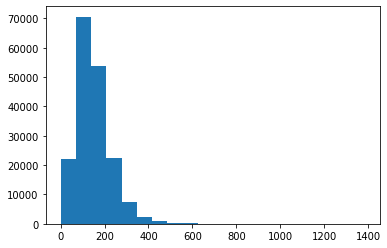

In [90]:
# Check distribution
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=20);

In [91]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [92]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [93]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name='char_vectorizer')

In [94]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [95]:
# CHeck character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [96]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
random_train_chars

't h e   m e d i a n   o v e r a l l   s u r v i v a l   w a s   @   m o n t h s   (   @   %   c o n f i d e n c e   i n t e r v a l   - l s b -   c i   - r s b -   ,   @   t o   n o t   r e a c h e d   )   i n   t h e   g r o u p   r e c e i v i n g   t h e   p e r t u z u m a b   c o m b i n a t i o n   ,   a s   c o m p a r e d   w i t h   @   m o n t h s   (   @   %   c i   ,   @   t o   @   )   i n   t h e   g r o u p   r e c e i v i n g   t h e   p l a c e b o   c o m b i n a t i o n   (   h a z a r d   r a t i o   f a v o r i n g   t h e   p e r t u z u m a b   g r o u p   ,   @   ;   @   %   c i   ,   @   t o   @   ;   p   <   @   )   ,   a   d i f f e r e n c e   o f   @   m o n t h s   .'

In [97]:
print(f'Charified text:\n {random_train_chars}')
print(f'Length of random_train_chars: {len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized chars:\n {vectorized_chars}')
print(f'\nLength of vectorized chars: {len(vectorized_chars[0])}')

Charified text:
 t h e   m e d i a n   o v e r a l l   s u r v i v a l   w a s   @   m o n t h s   (   @   %   c o n f i d e n c e   i n t e r v a l   - l s b -   c i   - r s b -   ,   @   t o   n o t   r e a c h e d   )   i n   t h e   g r o u p   r e c e i v i n g   t h e   p e r t u z u m a b   c o m b i n a t i o n   ,   a s   c o m p a r e d   w i t h   @   m o n t h s   (   @   %   c i   ,   @   t o   @   )   i n   t h e   g r o u p   r e c e i v i n g   t h e   p l a c e b o   c o m b i n a t i o n   (   h a z a r d   r a t i o   f a v o r i n g   t h e   p e r t u z u m a b   g r o u p   ,   @   ;   @   %   c i   ,   @   t o   @   ;   p   <   @   )   ,   a   d i f f e r e n c e   o f   @   m o n t h s   .
Length of random_train_chars: 275

Vectorized chars:
 [[ 3 13  2 15  2 10  4  5  6  7 21  2  8  5 12 12  9 16  8 21  4 21  5 12
  20  5  9 15  7  6  3 13  9 11  7  6 17  4 10  2  6 11  2  4  6  3  2  8
  21  5 12 12  9 22 11  4  8  9 22  3  7  6  7  3  8  2  5 11 13  2 10  4
 

## Creating a character-level embedding

In [98]:
len(char_vocab)

28

In [99]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper
                              mask_zero=True,
                              name='char_embed')

In [100]:
# Test character embedding layer
print(f'Charified text:\n {random_train_chars}\n')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars. (after vectorization and embedding):\n {char_embed_example}')
print(f'Character embedding shape: {char_embed_example.shape}')

Charified text:
 t h e   m e d i a n   o v e r a l l   s u r v i v a l   w a s   @   m o n t h s   (   @   %   c o n f i d e n c e   i n t e r v a l   - l s b -   c i   - r s b -   ,   @   t o   n o t   r e a c h e d   )   i n   t h e   g r o u p   r e c e i v i n g   t h e   p e r t u z u m a b   c o m b i n a t i o n   ,   a s   c o m p a r e d   w i t h   @   m o n t h s   (   @   %   c i   ,   @   t o   @   )   i n   t h e   g r o u p   r e c e i v i n g   t h e   p l a c e b o   c o m b i n a t i o n   (   h a z a r d   r a t i o   f a v o r i n g   t h e   p e r t u z u m a b   g r o u p   ,   @   ;   @   %   c i   ,   @   t o   @   ;   p   <   @   )   ,   a   d i f f e r e n c e   o f   @   m o n t h s   .

Embedded chars. (after vectorization and embedding):
 [[[ 0.0088791   0.03009801 -0.04237011 ... -0.01284451  0.04543462
    0.03435251]
  [-0.00360643 -0.01450406  0.04319414 ... -0.04144109 -0.04076989
    0.00787561]
  [ 0.03012316  0.01668027 -0.04920064 ...  0.04816656 -

In [101]:
len(random_train_chars)

705

### Building a Conv1D model to fit on character embeddings

In [102]:
# Make Conv1D on chars only
input_3 = layers.Input(shape=(1,), dtype='string')
char_vectors = char_vectorizer(input_3)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
output_3 = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.models.Model(input_3,
                                output_3,
                                name='model_3_conv1d_char_embeddings')

In [103]:
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [104]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
__________________________________

In [105]:
# Create char level datsets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [106]:
train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [107]:
# Fir the model on char only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 3s 5ms/step - loss: 1.2668 - accuracy: 0.4868 - val_loss: 1.0580 - val_accuracy: 0.5755
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0035 - accuracy: 0.6009 - val_loss: 0.9399 - val_accuracy: 0.6333
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9193 - accuracy: 0.6415 - val_loss: 0.8624 - val_accuracy: 0.6649


In [108]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.15313461, 0.40744808, 0.13070054, 0.24780306, 0.06091372],
       [0.15417215, 0.47346902, 0.06289083, 0.2181268 , 0.09134123],
       [0.16264477, 0.1795012 , 0.15970741, 0.4712654 , 0.02688123],
       ...,
       [0.02798641, 0.05617927, 0.3041875 , 0.05887178, 0.5527751 ],
       [0.07353178, 0.16378152, 0.40443698, 0.05200234, 0.30624735],
       [0.34636316, 0.23451462, 0.22048135, 0.18994212, 0.00869875]],
      dtype=float32)

In [109]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 0])>

In [110]:
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [111]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)

In [112]:
model_3_results

{'accuracy': 65.68913014696147,
 'f1': 0.6469180742532367,
 'precision': 0.6519329077804776,
 'recall': 0.6568913014696147}

## Model 4: Combining pretrained token embeddings + characters (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to the paper: https://arxiv.org/pdf/1612.05251.pdf (figure 1 and section 4.2)
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [113]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = sentence_encoder_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.models.Model(inputs=token_inputs,
                                    outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM
char_model = tf.keras.models.Model(inputs=char_inputs,
                                   outputs=char_bi_lstm)
# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat) # helps prevent overfitting
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name='model_4_token_and_char_embeddings')

In [171]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
USE (KerasLayer)                (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

In [115]:
!pip install keras

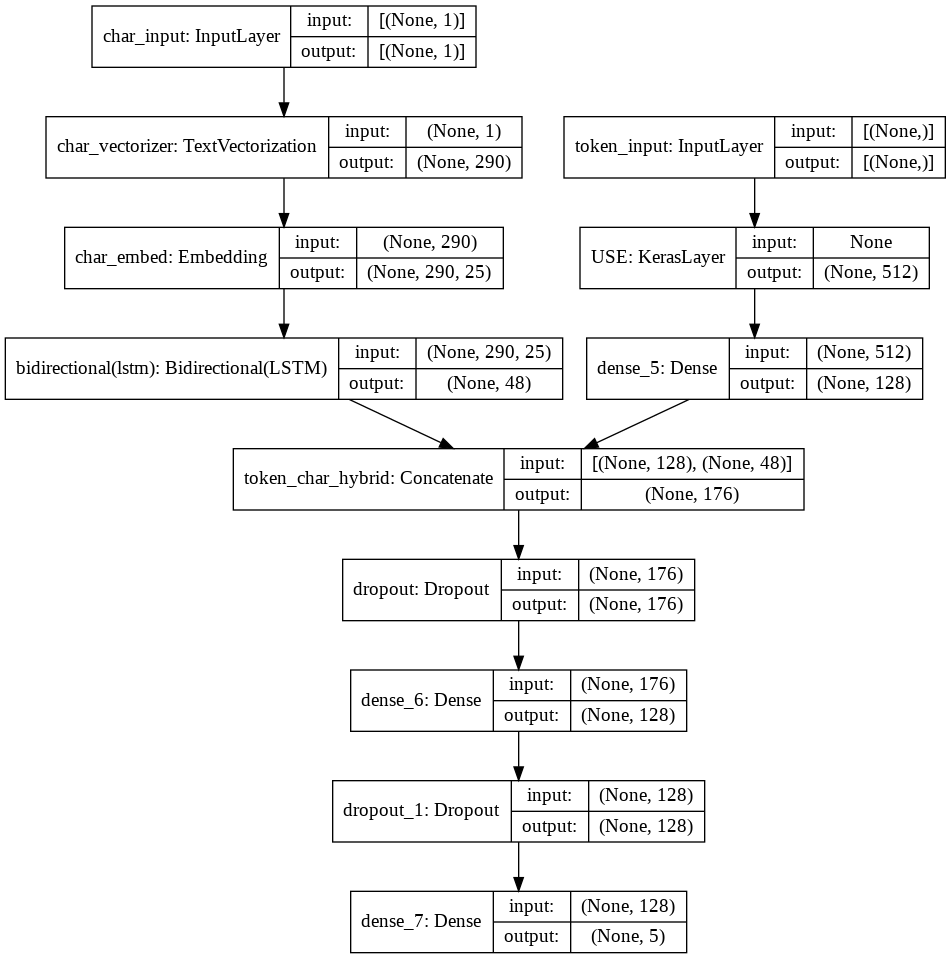

In [116]:
# Plot hybrid token and character model
from keras.utils.vis_utils import plot_model
plot_model(model_4, show_shapes=True)

In [117]:
model_4.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

### Combining token and character data into a tf.data Dataset

In [121]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [120]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [122]:
train_labels_one_hot[:5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [124]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # Make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot)) # Make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [125]:
# Repeat the above steps for validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # Make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot)) # Make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [127]:
# Check out char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

### Fitting a model on token and character-level sequences

In [136]:
history_4 = model_4.fit(train_char_token_dataset,
                        epochs=3,
                        steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                        validation_data=val_char_token_dataset,
                        validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 33s 47ms/step - loss: 0.9806 - accuracy: 0.6097 - val_loss: 0.7752 - val_accuracy: 0.6995
Epoch 2/3
562/562 [==============================] - 24s 43ms/step - loss: 0.7956 - accuracy: 0.6961 - val_loss: 0.7119 - val_accuracy: 0.7291
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.7731 - accuracy: 0.7043 - val_loss: 0.6869 - val_accuracy: 0.7364


In [128]:
int(0.1*len(train_char_token_dataset)), int(0.1*len(val_char_token_dataset))

(562, 94)

In [134]:
np.array(val_chars).shape, np.array(val_sentences).shape

((30212,), (30212,))

In [135]:
np.array(train_chars).shape, np.array(train_sentences).shape

((180040,), (180040,))

In [137]:
model_1_results

{'accuracy': 78.43572090560042,
 'f1': 0.7821911294429905,
 'precision': 0.7817292056992919,
 'recall': 0.7843572090560043}

In [138]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6929 - accuracy: 0.7357


[0.6928958296775818, 0.7356679439544678]

In [139]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.1233891e-01, 4.2148089e-01, 4.4388040e-03, 1.5396202e-01,
        7.7793887e-03],
       [2.8782943e-01, 5.3903300e-01, 3.8519604e-03, 1.6713341e-01,
        2.1521701e-03],
       [3.6946666e-01, 1.3395631e-01, 5.5900387e-02, 4.0524200e-01,
        3.5434663e-02],
       ...,
       [9.7363855e-04, 9.6245231e-03, 5.3401209e-02, 3.5732790e-04,
        9.3564326e-01],
       [7.8354413e-03, 5.7784423e-02, 2.2041045e-01, 3.3602477e-03,
        7.1060944e-01],
       [3.6356062e-01, 4.3443626e-01, 1.3564314e-01, 2.7642852e-02,
        3.8717169e-02]], dtype=float32)

In [166]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [142]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.566794651132,
 'f1': 0.7331897351728393,
 'precision': 0.7357177210425165,
 'recall': 0.7356679465113201}

In [143]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

> **Note:** Any engineered feature used to train a model need to be available at test time

### Create positional embeddings

In [144]:
# How many different line number are there
train_df['line_number'].value_counts()


0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

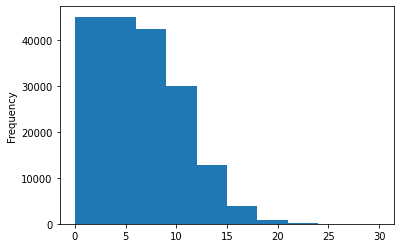

In [148]:
train_df.line_number.plot.hist()

In [149]:
train_df['line_number'].to_numpy()

array([ 0,  1,  2, ...,  9, 10, 11])

In [151]:
# Use tensorflow to create one-hot-encoded tensors of our 'line_number' column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [153]:
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

In [154]:
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

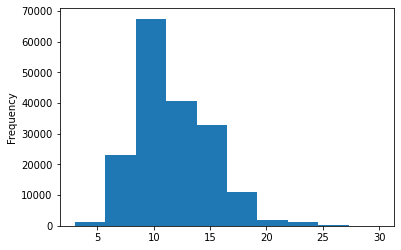

In [156]:
# Distribution
train_df.total_lines.plot.hist()

In [157]:
# Check the coverage of a 'total_lines' value of 20
np.percentile(train_df.total_lines, 95)

18.0

In [165]:
# Create one-hot encoded tensors
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

In [164]:
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

### Building a tribrid embeddign model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the `line_number` feature
4. Create a model for the `total_lines` feature
5. Combine the outputs of 1 & 2 using the `tf.keras.layers.Concatenate`
6. Combine the output of 3, 4, & 5 using the `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a `tf.keras.Model`



In [193]:
train_line_numbers_one_hot[0].shape

TensorShape([15])

In [202]:
# 1. Token inputs
token_inputs_5 = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings_5 = sentence_encoder_layer(token_inputs_5)
token_outputs_5 = layers.Dense(128, activation='relu')(token_embeddings_5)
token_model_5 = tf.keras.Model(inputs=token_inputs_5,
                               outputs=token_outputs_5)

# 2. Char inputs
char_inputs_5 = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vectors_5 = char_vectorizer(char_inputs_5)
char_embeddings_5 = char_embed(char_vectors_5)
char_bi_lstm_5 = layers.Bidirectional(layers.LSTM(24))(char_embeddings_5)
char_model_5 = tf.keras.Model(inputs=char_inputs_5,
                            outputs=char_bi_lstm_5)

# 3. Line numbers model
# inputs, shape = ?
# dense layer with 32 units & relu activation
# combine inputs and dense layer into model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_inputs')
line_number_x = layers.Dense(units=32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_x)

# 4. Total lines
# same for step 3
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_inputs')
total_lines_x = layers.Dense(units=32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=total_lines_x)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model_5.output, char_model_5.output])

z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])
# 7. Create output layer
output_layer_5 = layers.Dense(5, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                total_lines_model.input,
                                token_model_5.input,
                                char_model_5.input],
                        outputs=output_layer_5,
                        name="model_5_tribrid_embedding_model")

In [203]:
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
USE (KerasLayer)                (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________

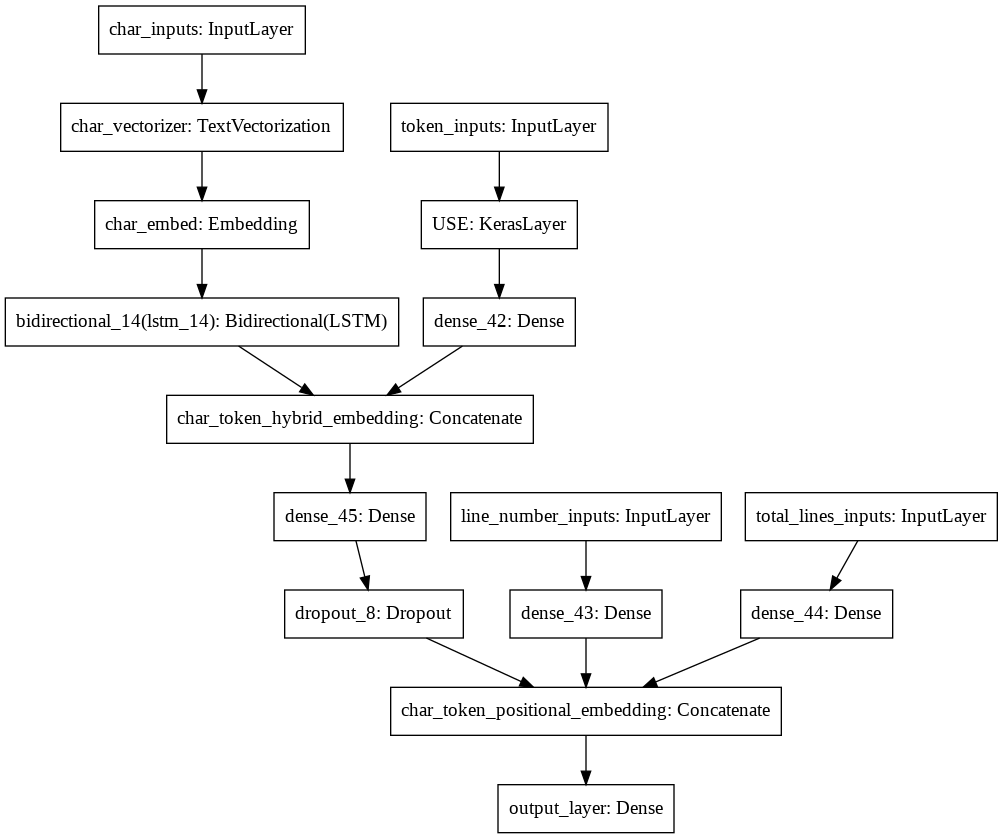

In [205]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [212]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Create tribrid embedding dataset using tf.data

In [208]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                               train_total_lines_one_hot,
                                                               train_sentences,
                                                               train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# For validation dataset 
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                             val_total_lines_one_hot,
                                                             val_sentences,
                                                             val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [209]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [213]:
history_5 = model_5.fit(train_char_token_pos_dataset,
                        steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                        epochs=3,
                        validation_data=val_char_token_pos_dataset,
                        validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 34s 48ms/step - loss: 1.1003 - accuracy: 0.7186 - val_loss: 0.9846 - val_accuracy: 0.8029
Epoch 2/3
562/562 [==============================] - 25s 44ms/step - loss: 0.9695 - accuracy: 0.8149 - val_loss: 0.9477 - val_accuracy: 0.8285
Epoch 3/3
562/562 [==============================] - 23s 40ms/step - loss: 0.9502 - accuracy: 0.8242 - val_loss: 0.9373 - val_accuracy: 0.8295


In [214]:
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 19s 21ms/step - loss: 0.9366 - accuracy: 0.8326


[0.9365603923797607, 0.832649290561676]

In [216]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

array([[0.5272832 , 0.11019561, 0.01024752, 0.3371374 , 0.0151362 ],
       [0.53119767, 0.09977625, 0.05476694, 0.29994595, 0.01431325],
       [0.24894007, 0.10076556, 0.11684578, 0.4672648 , 0.06618376],
       ...,
       [0.03124407, 0.0956607 , 0.03575639, 0.02597911, 0.8113597 ],
       [0.03239177, 0.296277  , 0.0722012 , 0.0313136 , 0.56781644],
       [0.26134273, 0.569038  , 0.08792262, 0.0418879 , 0.0398088 ]],
      dtype=float32)

In [220]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [221]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.2649278432411,
 'f1': 0.8317077935195797,
 'precision': 0.8312163552558763,
 'recall': 0.832649278432411}

In [222]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [224]:
model_4_results

{'accuracy': 73.566794651132,
 'f1': 0.7331897351728393,
 'precision': 0.7357177210425165,
 'recall': 0.7356679465113201}

In [226]:
# Compare model results
all_model_results = pd.DataFrame({'model_0_baseline': baseline_results,
                                 'model_1_custom_token_embedding:': model_1_results,
                                 'model_2_pretrained_token_embedding': model_2_results,
                                 'model_3_custom_char_embedding': model_3_results,
                                 'model_4_hybrid_char_token_embedding': model_4_results,
                                 'model_5_pos_char_token_embeddinge': model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding:,78.435721,0.781729,0.784357,0.782191
model_2_pretrained_token_embedding,71.455051,0.715249,0.714551,0.711577
model_3_custom_char_embedding,65.689130,0.651933,0.656891,0.646918
model_4_hybrid_char_token_embedding,73.566795,0.735718,0.735668,0.733190
model_5_pos_char_token_embeddinge,83.264928,0.831216,0.832649,0.831708


In [227]:
# Reduce accuracy
all_model_results['accuracy'] = all_model_results['accuracy'] / 100

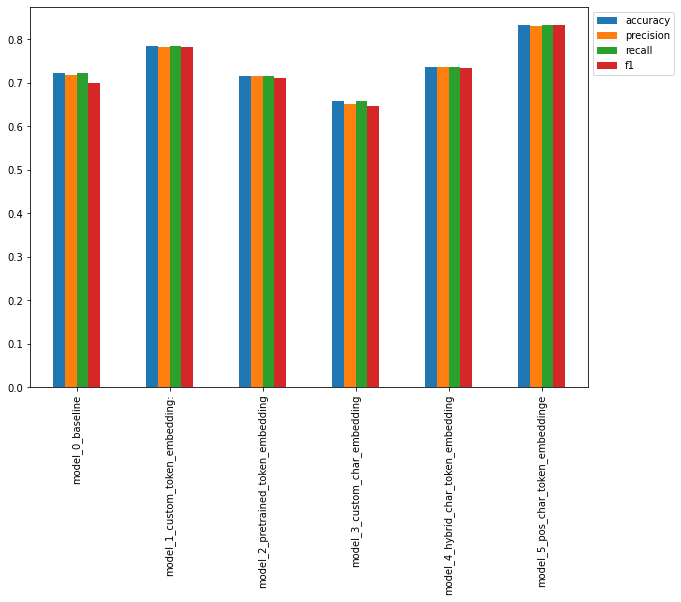

In [229]:
# plot
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

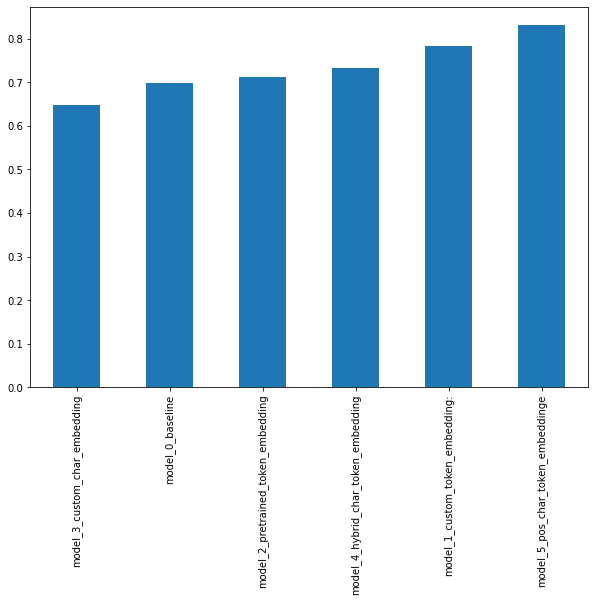

In [230]:
# Sort the model results by f1-score
all_model_results.sort_values('f1', ascending=True)['f1'].plot(kind='bar', figsize=(10, 7));

## Save and load model

In [231]:
# Save the best performing model to SavedModel format (default)
model_5.save('skimlit_tribrid_model')

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [ ]:
# Load in best performing model
# loaded_model = tf.keras.models.load_model('skimlit_tribrid_model')
# Currently giving an error

## Download and load in a pretrained model from Google Storage


In [235]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [236]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model -d skimlit_gs_model

--2021-08-22 07:17:32--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 172.217.218.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962957902 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 918.35M  92.5MB/s    in 11s     

2021-08-22 07:17:44 (86.6 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962957902/962957902]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-000

In [ ]:
# Load in download Google Storage model
# loaded_gs_model = tf.keras.models.load_model('skimlit_gs_model/skimlit_tribrid_model/')

In [ ]:
# Evaluate
# loaded_gs_model.evaluate(val_char_token_pos_dataset)


## Challenges
Try these out before moving onto the next module.

The GitHub has an example of how to do each but I'd encourage you to try it for yourself first (you've got this!).

1. Turn the test data samples into a tf.data Dataset (fast loading) and then evaluate (make predictions) the best performing model on the test samples.
2. Find the most wrong predictions from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probability).
3. Make example predictions (on RCT abstracts from the wild), you can go to PubMed to find these: https://pubmed.ncbi.nlm.nih.gov/, find and use our model to predict on 3-4 different abstracts from the wild.
Some examples: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/skimlit_example_abstracts.json
